In [7]:
import os
SLURM_PATH = '/home/yandex/MLWG2025/amitr5'
CACHE_DIR = '' 

if SLURM_PATH in os.getcwd():
        CACHE_DIR = f'{SLURM_PATH}/tmp/hf_cache' 
        os.makedirs(CACHE_DIR, exist_ok=True)
        os.environ["PIP_PATH"] = f"{SLURM_PATH}/BaryGNN/anaconda3/envs/conf/bin/pip"
        os.environ["TEMP_DIR"] = CACHE_DIR
        os.environ["HF_HOME"] = CACHE_DIR
        os.environ["TRANSFORMERS_CACHE"] = CACHE_DIR
        os.environ["HF_DATASETS_CACHE"] = CACHE_DIR
        # Hugging Face uses HUGGINGFACE_HUB_CACHE (HF_HUB_CACHE is ignored)
        os.environ["HUGGINGFACE_HUB_CACHE"] = CACHE_DIR
        os.environ["TMPDIR"] = CACHE_DIR
        os.environ["XDG_CACHE_HOME"] = CACHE_DIR
        # os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Imports #
import numpy as np
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor, AutoModelForSeq2SeqLM, AutoTokenizer
import torch
import os
import pandas as pd
# from datasets import load_dataset
# import torch.nn.functional as F
from tqdm.auto import tqdm
# Project imports #

import utils
from mind2web.dataloader import build_datasets_dict, subsample_by_annotation ,MultiChoiceDataset, MultiChoiceDatasetRandom
from utils import CACHE_DIR
from utils import log_response


# sys.path.append('./Mind2Web/src')

In [9]:
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xl", cache_dir=CACHE_DIR)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "osunlp/MindAct_ActionPrediction_flan-t5-xl"

# model = AutoModelForSeq2SeqLM.from_pretrained(model_name, cache_dir=CACHE_DIR, device_map="auto")
# model.eval();

ds_dict = build_datasets_dict(MultiChoiceDataset.id2split.values(),cache_dir=CACHE_DIR);


Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

In [10]:
utils.reload('mind2web.dataloader')
from mind2web.dataloader import subsample_by_annotation, MultiChoiceDataset, MultiChoiceDatasetRandom  # <-- Re-import after reload

cal_dict, test_dict, pen_dict = {}, {}, {}
seed = 42
frac = 0.2
num_candidates=5
max_context_len=512

for split, test_split in ds_dict.items():
    cal_set, test_set = subsample_by_annotation(test_split, frac=frac, seed=seed)
    cal_set, pen_set = subsample_by_annotation(cal_set, frac=0.5, seed=seed)
    cal_dict[split] = MultiChoiceDataset(
        cal_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len, cache_prompt=True, cache_tokenized=True
    )
    pen_dict[split] = MultiChoiceDataset(
        pen_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len, cache_prompt=True, cache_tokenized=True
    )

    test_dict[split] = MultiChoiceDataset(
        test_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len,cache_prompt=True, cache_tokenized=True
    )
    # cal_dict[split] = MultiChoiceDatasetRandom(
    #     cal_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len, top_k=10, neg_ratio=0.05)
    
    # pen_dict[split] = MultiChoiceDatasetRandom(
    #     pen_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len)

    # test_dict[split] = MultiChoiceDatasetRandom(
    #     test_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len, top_k=25, neg_ratio=0.05)

mind2web.dataloader- reloaded


In [8]:
utils.reload('utils.helpers','utils.llm_utils')
import pandas as pd
import gc
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import mind2web


def run_split_random(split_name, ds, model, tokenizer, batch_size=7, num_iterations=1, temperature=1):
    all_records  = []
    for rand_idx in range(num_iterations):
        # Clear GPU memory before next iteration
        torch.cuda.empty_cache()
        gc.collect()
        # ds.seed = rand_idx
        loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=mind2web.dataloader.multichoice_collate_fn)
        results = utils.llm.batch_generate(model, tokenizer, loader, split_name=split_name, temperature=temperature)
        records = pd.DataFrame(results)
        records['rand_idx'] = rand_idx
        all_records.append(records)

    final_df = pd.concat(all_records, ignore_index=True)
    return final_df

df_list = []
for split_name, ds_split in tqdm(test_dict.items()):
    df = run_split_random(split_name, ds_split, model, tokenizer, temperature=6)
    df_list.append(df)

results_df = pd.concat(df_list, ignore_index=True)
results_df.to_pickle("test_df.pkl")

utils.helpers- reloaded
utils.llm_utils- reloaded


  0%|          | 0/3 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 610.00 MiB. GPU 0 has a total capacity of 11.90 GiB of which 202.88 MiB is free. Including non-PyTorch memory, this process has 11.69 GiB memory in use. Of the allocated memory 11.42 GiB is allocated by PyTorch, and 107.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [208]:
results_df.head()

,relative_idx,annotation_id,action_uid,output_text,target_text,choices_logits,test_split,rand_idx
0,0,0572899e-7c07-4a2f-a77b-bba4f432a7ad,7194e8bf-6cf3-4f36-a37f-70fd065c4aac,C. Action: CLICK,C. Action: CLICK,"{'A': -3.084818124771118, 'B': -5.401023387908...",0,0
1,1,0572899e-7c07-4a2f-a77b-bba4f432a7ad,aa34483b-ad90-4054-b38b-d29157a1c517,B. Action: CLICK,B. Action: CLICK,"{'A': 0.7131706476211548, 'B': 6.4016227722167...",0,0
2,2,0572899e-7c07-4a2f-a77b-bba4f432a7ad,49b0e49e-deab-4400-987a-4cfd6ba09a84,D. Action: CLICK,D. Action: CLICK,"{'A': 0.5229284763336182, 'B': -3.964406251907...",0,0
3,3,0572899e-7c07-4a2f-a77b-bba4f432a7ad,aa40812d-f178-4d28-b6de-6ec9ca1b2758,B. Action: TYPE Value: SFTBAO,B. Action: TYPE Value: SFTBAO,"{'A': -1.5480059385299683, 'B': 6.001170635223...",0,0
4,4,0572899e-7c07-4a2f-a77b-bba4f432a7ad,998b187b-44a3-4f3d-93de-e00fdd23e4cf,B. Action: TYPE Value: Joe,B. Action: TYPE Value: Joe,"{'A': -0.452083945274353, 'B': 5.8127889633178...",0,0


In [211]:
utils.reload('utils.helpers')
results_df['choices_probs'] = results_df['choices_logits'].apply(lambda x: (utils.helpers.choices_softmax(x, temperature=6.0)))
results_df['choices_probs']

utils.helpers- reloaded


0      {'A': 0.139629527926445, 'B': 0.09491278976202...
1      {'A': 0.18216946721076965, 'B': 0.470131605863...
2      {'A': 0.18113406002521515, 'B': 0.085742481052...
3      {'A': 0.1509549766778946, 'B': 0.5312207937240...
4      {'A': 0.17022627592086792, 'B': 0.483607709407...
                             ...                        
105    {'A': 0.15855087339878082, 'B': 0.075187072157...
106    {'A': 0.2257235050201416, 'B': 0.4127052128314...
107    {'A': 0.17477934062480927, 'B': 0.491915583610...
108    {'A': 0.13793626427650452, 'B': 0.560035169124...
109    {'A': 0.3012753427028656, 'B': 0.1248216852545...
Name: choices_probs, Length: 110, dtype: object

In [209]:
cal_df.head()

,relative_idx,annotation_id,action_uid,output_text,target_text,choices_probs,test_split,rand_idx,target_label,target_action,target_value,pred_label,pred_action,pred_value,correct,true_prob,pred_prob
0,0,0572899e-7c07-4a2f-a77b-bba4f432a7ad,7194e8bf-6cf3-4f36-a37f-70fd065c4aac,C. Action: CLICK,C. Action: CLICK,"{'A': 0.139629527926445, 'B': 0.09491277486085...",0,0,C,CLICK,None,C,CLICK,None,True,0.556245,0.556245
1,1,0572899e-7c07-4a2f-a77b-bba4f432a7ad,aa34483b-ad90-4054-b38b-d29157a1c517,B. Action: CLICK,B. Action: CLICK,"{'A': 0.18216946721076965, 'B': 0.470131665468...",0,0,B,CLICK,None,B,CLICK,None,True,0.470132,0.470132
2,2,0572899e-7c07-4a2f-a77b-bba4f432a7ad,49b0e49e-deab-4400-987a-4cfd6ba09a84,D. Action: CLICK,D. Action: CLICK,"{'A': 0.18113403022289276, 'B': 0.085742458701...",0,0,D,CLICK,None,D,CLICK,None,True,0.461323,0.461323
3,3,0572899e-7c07-4a2f-a77b-bba4f432a7ad,aa40812d-f178-4d28-b6de-6ec9ca1b2758,B. Action: TYPE Value: SFTBAO,B. Action: TYPE Value: SFTBAO,"{'A': 0.1509549766778946, 'B': 0.5312207341194...",0,0,B,TYPE,SFTBAO,B,TYPE,SFTBAO,True,0.531221,0.531221
4,4,0572899e-7c07-4a2f-a77b-bba4f432a7ad,998b187b-44a3-4f3d-93de-e00fdd23e4cf,B. Action: TYPE Value: Joe,B. Action: TYPE Value: Joe,"{'A': 0.17022626101970673, 'B': 0.483607649803...",0,0,B,TYPE,Joe,B,TYPE,Joe,True,0.483608,0.483608


In [169]:
len(results_df)
len(results_df.groupby(['annotation_id','rand_idx']))

100

In [ ]:
def get_threshold(scores, alpha: float):
    N = len(scores)
    k = int(np.ceil((N + 1) * (1 - alpha)))
    sorted_scores = np.sort(scores.values)
    threshold = sorted_scores[k - 1]
    return threshold

utils.reload('utils.helpers')

# cal_df = pd.read_pickle("cal_results.pkl")
# test_df = pd.read_pickle("test_results.pkl")
# cal_df = utils.helpers.add_eval_columns(results_df)
# cal_df['correct'] = cal_df['pred_label'] == cal_df['label']
# cal_df['true_prob'] = cal_df.apply(lambda row: row['choices_probs'][row['label']] if row['label'] in row['choices_probs'] else 0, axis=1)


cal_df['choices_probs'] = utils.helpers.softmax_with_temperature_from_probs(cal_df['choices_probs'], temperature=6.0)
cal_df['true_prob'] = cal_df.apply(lambda row: row['choices_probs'][row['label']] if row['label'] in row['choices_probs'] else 0, axis=1)
# google's nonconformity score
cal_grouped = cal_grouped = cal_df.groupby(['annotation_id','rand_idx'])
score_per_group = 1 - cal_grouped['true_prob'].min()

threshold = get_threshold(score_per_group, alpha=0.1)
test_df = pd.read_pickle("test_results.pkl")
# test_df = utils.helpers.add_eval_columns(test_df, threshold=threshold)

utils.helpers- reloaded


NameError: name 'cal_df' is not defined

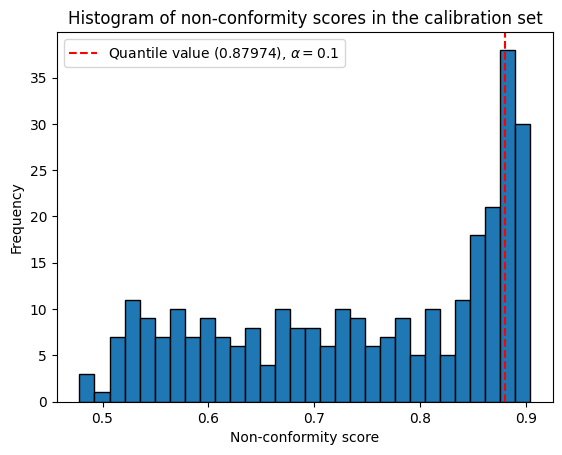

A good predictor should have low non-conformity scores, concentrated at the left side of the figure


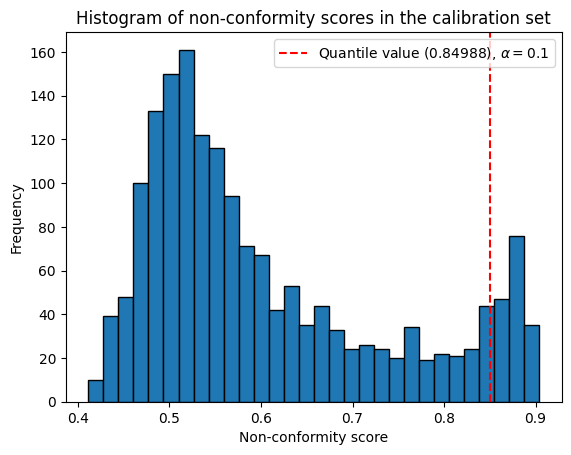

A good predictor should have low non-conformity scores, concentrated at the left side of the figure


In [201]:
utils.plot.nonconformity_histogram(score_per_group, get_threshold(score_per_group, alpha=0.2))
utils.plot.nonconformity_histogram(1-cal_df['true_prob'], get_threshold(1-cal_df['true_prob'], alpha=0.1))
#0.89301
#0.8892 - rnd 1 batch
# 0.89181 -soft normal
# 0.8867 - 3 iter rand topk 25
# 0.890 - 3iter topk 10

In [202]:
utils.reload('utils')
    
test_df['choices_probs'] = test_df['choices_probs'].apply(lambda x:utils.helpers.softmax_with_temperature_from_probs(x, temperature=6.0))
test_df["pred_set"] = test_df['choices_probs'].apply(lambda row: [ label for label, prob in row.items() if 1 - prob <= threshold])
test_df["pred_set_size"] = test_df["pred_set"].apply(len)

utils- reloaded


In [203]:
print(f'Average pred_set size: {test_df["pred_set_size"].mean()}, Median size: {test_df["pred_set_size"].median()}, Prop of 1> : {np.mean(test_df['pred_set_size'] > 1)}')
true_in_pred = test_df.apply(lambda row: row['label'] in row['pred_set'], axis=1).mean()
print(true_in_pred)

Average pred_set size: 2.09346439041214, Median size: 2.0, Prop of 1> : 0.9413692015864804
0.9270563890325918


In [198]:
print(f'Average pred_set size: {test_df["pred_set_size"].mean()}, Median size: {test_df["pred_set_size"].median()}, Prop of 1> : {np.mean(test_df['pred_set_size'] > 1)}')
true_in_pred = test_df.apply(lambda row: row['label'] in row['pred_set'], axis=1).mean()
print(true_in_pred)

Average pred_set size: 2.469908604931885, Median size: 2.0, Prop of 1> : 0.991722710812209
0.9696499396447663


In [191]:
print(f'Average pred_set size: {test_df["pred_set_size"].mean()}, Median size: {test_df["pred_set_size"].median()}, Prop of 1> : {np.mean(test_df['pred_set_size'] > 1)}')
true_in_pred = test_df.apply(lambda row: row['label'] in row['pred_set'], axis=1).mean()
print(true_in_pred)

Average pred_set size: 2.3091912398689427, Median size: 2.0, Prop of 1> : 0.9806863252284876
0.9574064493878255


In [154]:
x=score_per_group.reset_index()
mask = (x["rand_idx"]==9)

y = get_threshold(x[mask]['true_prob'], alpha=0.1)
pred_set = test_df['choices_probs'].apply(lambda row: [ label for label, prob in row.items() if 1 - prob <= y])
pred_set_size = pred_set.apply(len)

print(f'Average pred_set size: {pred_set_size.mean()}, Median size: {pred_set_size.median()}, Prop of 1> : {np.mean(pred_set_size > 1)}')
test_df['naive_pred_set'] = pred_set
true_in_pred = test_df.apply(lambda row: row['label'] in row['naive_pred_set'], axis=1).mean()
print(f'prop {true_in_pred:.4f}, new threshold: {y:.4f}, diff:{y - threshold:.4f}')

Average pred_set size: 2.4098982583204003, Median size: 2.0, Prop of 1> : 0.9877565097430592
prop 0.9648, new threshold: 0.8889, diff:0.0000


In [15]:
import utils
import pandas as pd


In [155]:
x[mask]['true_prob']

9      0.887015
19     0.784539
29     0.538118
39     0.579339
49     0.788014
         ...   
959    0.829705
969    0.903129
979    0.745532
989    0.899334
999    0.900998
Name: true_prob, Length: 100, dtype: float64

In [83]:
x = pd.read_pickle('test_results.pkl')
x["pred_set"] = x['choices_probs'].apply(lambda row: [ label for label, prob in row.items() if 1 - prob <= 0.9998])
x["pred_set_size"] = x["pred_set"].apply(len)

# Example

In [ ]:
import utils
import pandas as pd
import numpy as np
utils.reload('utils.helpers')

cal_df = pd.read_pickle('cal_df.pkl')
cal_df = utils.helpers.add_eval_columns(cal_df)
label_map = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5}
y_cal = cal_df["target_label"].map(label_map)

alpha = 0.05
lambda_grid = np.linspace(0.0, 1.0, 1000)

best_lambda, results = utils.helpers.tune_lambda_group_risk(
    cal_df=cal_df,
    y_cal=y_cal,
    alpha=alpha,
    lambda_grid=lambda_grid,
)

best = results[best_lambda]
best, best_lambda

In [ ]:

alpha =  1-best_lambda
logits = cal_df['choices_logits'].apply(lambda x: list(x.values()))
logits = np.array(logits.tolist()).reshape(-1, 6) # 6 = A,.., F
logits += np.abs(logits.min(axis=1).reshape(-1,1))
logits[:,0] = logits[:,0] * (alpha)

preds_raw = logits.argmax(axis=1) + 65
preds = [chr(x) for x in preds_raw]

preds_df = pd.DataFrame(preds, columns=['pred'])


import matplotlib.pyplot as plt
# plt.figure(figsize=(6,4))
cal_df['target_label'].hist(alpha=0.5, label='Ground Truth', )
preds_df['pred'].hist(alpha=0.7, label='Reweighted preds', )
cal_df['pred_label'].hist(alpha=0.5, label='Original preds',)
plt.title(rf'Label distribution ($\lambda = {1-best_lambda:.4f}$)')
plt.legend()
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()


In [ ]:
pen_df = pd.read_pickle('pen_df.pkl')
pen_df = utils.helpers.add_eval_columns(pen_df)
logits = pen_df['choices_logits'].apply(lambda x: list(x.values()))
logits = np.array(logits.tolist()).reshape(-1, 6) # 6 = A,.., F
logits += np.abs(logits.min(axis=1).reshape(-1,1))
logits[:,0] = logits[:,0] * (1-best_lambda) #(1 - 0.84)

preds_raw = logits.argmax(axis=1) + 65
preds = [chr(x) for x in preds_raw]
print((preds == pen_df['target_label']).mean())
print(pen_df['correct'].mean())


preds_df = pd.DataFrame(preds, columns=['pred'])
preds_df['correct'] = (preds_df['pred'] == pen_df['target_label'])
preds_df[preds_df['correct'] == False].value_counts()


pen_df['target_label'].hist(alpha=0.5, label='Ground Truth')
preds_df['pred'].hist(alpha=0.7, label='Reweighted preds')
pen_df['pred_label'].hist(alpha=0.5, label='original pred')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title(rf'Label distribution ($\lambda = {1-best_lambda:.4f}$)')
plt.legend()
plt.tight_layout()

